In [11]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 깔금한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 불필요한 경고를 무시합니다 (사이파이 이슈 #5998 참조)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [12]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/rickiepark/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [13]:
fetch_housing_data()

In [14]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [15]:
housing = load_housing_data()
housing.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY


In [16]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 3.0, 6.0, np.inf],
                               labels=[1, 2, 3])

# 참고 : 옛날 코드
# housing["income_cat"] = np.ceil(housing["income_cat"] / 1.5)
# housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace="True")  # 5 이상은 5로

In [17]:
housing["income_cat"].value_counts()

2    10875
1     7403
3     2362
Name: income_cat, dtype: int64

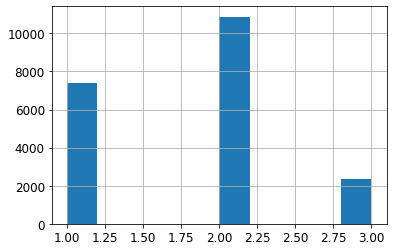

In [18]:
housing["income_cat"].hist()

In [19]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

strat_test_set.head()    

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
10266,-117.84,33.89,24.0,3935.0,625.0,1912.0,593.0,5.7951,226900.0,<1H OCEAN,2
12723,-121.38,38.59,38.0,1839.0,287.0,685.0,276.0,4.5313,189400.0,INLAND,2
4264,-118.31,34.10,40.0,4984.0,2158.0,4828.0,2028.0,1.6903,350000.0,<1H OCEAN,1
12740,-121.35,38.61,25.0,4916.0,1243.0,2140.0,1136.0,2.5511,134100.0,INLAND,1
2787,-118.45,37.37,26.0,3135.0,524.0,1385.0,523.0,4.3370,139700.0,INLAND,2


In [20]:
from sklearn.model_selection import train_test_split

strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, random_state=42, stratify=housing["income_cat"])

strat_test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
10266,-117.84,33.89,24.0,3935.0,625.0,1912.0,593.0,5.7951,226900.0,<1H OCEAN,2
12723,-121.38,38.59,38.0,1839.0,287.0,685.0,276.0,4.5313,189400.0,INLAND,2
4264,-118.31,34.10,40.0,4984.0,2158.0,4828.0,2028.0,1.6903,350000.0,<1H OCEAN,1
12740,-121.35,38.61,25.0,4916.0,1243.0,2140.0,1136.0,2.5511,134100.0,INLAND,1
2787,-118.45,37.37,26.0,3135.0,524.0,1385.0,523.0,4.3370,139700.0,INLAND,2


In [21]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

2    0.526890
1    0.358769
3    0.114341
Name: income_cat, dtype: float64

In [22]:
housing["income_cat"].value_counts() / len(housing)

2    0.526890
1    0.358672
3    0.114438
Name: income_cat, dtype: float64

In [23]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),  # 전체에서의 비율
    "Stratified": income_cat_proportions(strat_test_set), # 계층적 샘플링한 경우
    "Random": income_cat_proportions(test_set), # 계층적 샘플링 안 한 경우 (그냥 무작위)
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [24]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.358672,0.358769,0.364583,1.647981,0.027016
2,0.526890,0.526890,0.525921,-0.183908,0.000000
3,0.114438,0.114341,0.109496,-4.318374,-0.084674
